Use SPY SPX data which contains

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt

from scipy.optimize import least_squares

## <a id = "top">Table of Content</a>
### [0. Preprocess Data](#p0)
### [1. Black Scholes Implied Vol](#p1)
- ##### [Generate Lognormal vol](#p11)
- ##### [Lognormal Volatility Smile](#p12)

### [2. Bachelier Implied Vol](#p2)
- ##### [Generate Normal vol](#p21)
- ##### [Normal Volatility Smile](#p22)
- ##### [Lognormal vs Normal vol](#p23)

### [3. Displaced Diffusion Model](#p3)
- ##### [ATM volatility](#p31)
- ##### [DD calibration](#p32)
- ##### [DD Smile](#p33)

### [4. SABR Model](#p4)
- ##### [Calibrate SABR Model](#p41)
- ##### [SABR Smile](#p42)


## <a id = "p0"> 0. </a> Preprocess Data [back to table of contents](#top)

In [6]:
df_zero = pd.read_csv("zero_rates_20201201.csv")
df_spx = pd.read_csv("SPX_options.csv")
df_spy = pd.read_csv("SPY_options.csv")
S0_spx = 3662.45
S0_spy = 366.02

## <a id = "p1"> 1. </a> Black Scholes Implied Vol [back to table of contents](#top)

- input: option price
- output: implied volatility
- method: brenqt solver (a root finding algorithm)

The Black-Scholes formula for a call option is given by

\begin{equation}
\begin{split}
C(S,K,r,\sigma,T) &= S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)\\
            d_1 &= \frac{\log \frac{S_0}{K} +
            \left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}, \hspace{2cm} d_2 = d_1 - \sigma\sqrt{T}\\
\end{split}            
\end{equation}


##### <a id = "p11"> </a> Generate Lognormal vol [back to table of contents](#top)

In [7]:
def BlackScholes(S, K, r, sigma, T, payoff):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if payoff == "C":
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    elif payoff == "P":
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    
def impliedVol(S, K, r, price, T, payoff):
    try:
        impliedVol = brentq(lambda x: price -
                            BlackScholes(S, K, r, x, T, payoff),
                            1e-6, 1000000.0)
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [8]:
def get_lognormal_smile(Option,Rate,S0):
    start_date = pd.Timestamp(str(df_spx["date"].unique()[0])).date()
    Option["T"] = Option["exdate"].apply(
        lambda x:(pd.Timestamp(str(x)).date() - start_date).days)
    Option["r"] = Option["T"].apply(lambda x:np.interp(x,Rate["days"],Rate["rate"])/100)

    Option["F"] = S0 * np.exp(Option["r"] * Option["T"] / 365)

    ### filter out ITM options which is unliquid
    call = Option[Option["cp_flag"] == "C"]
    call["mid_price"] = (call["best_bid"] + call["best_offer"])/2
    call = call[call["strike_price"]/1000 >= S0]

    put = Option[Option["cp_flag"] == "P"]
    put["mid_price"] = (put["best_bid"] + put["best_offer"])/2
    put = put[put["strike_price"]/1000 <= S0]

    df_smile = pd.concat([put,call])
    df_smile["impvol"] = df_smile.apply(lambda x:
                                        impliedVol(S0, 
                                                   x["strike_price"]/1000, 
                                                   x["r"], 
                                                   x["mid_price"], 
                                                   x["T"]/365,
                                                   x["cp_flag"]),
                                        axis = 1)
    smiles = []
    for T in df_smile["T"].unique():
        smiles += [df_smile[df_smile["T"] == T]]
    return smiles

def plot_lognormal_smile(smiles,name):
    plt.figure(figsize=(10, 6))

    for i, df in enumerate(smiles):
        y_values = df['impvol']
        plt.scatter(df['strike_price'] / 1000, y_values, marker='s',\
                    label=f"Maturity = {df['T'].iloc[0]} Days")

    plt.xlabel('Strike_price')
    plt.ylabel('Implied Volitality')
    plt.title(f'{name} Volitality Smile')
    plt.legend()

    plt.grid(True)
    plt.show()   

##### <a id = "p12"> </a> Lognormal Volatility Smile [back to table of contents](#top)

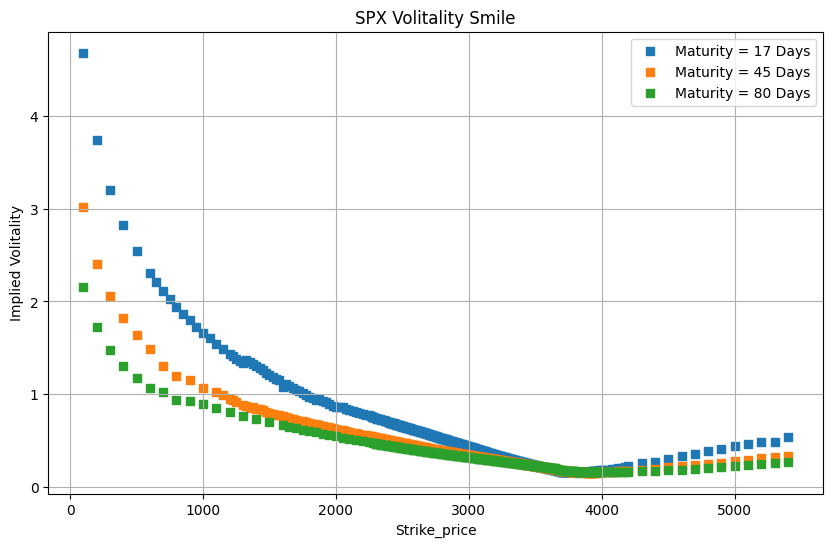

In [9]:
spx_smile = get_lognormal_smile(df_spx,df_zero,S0_spx)
plot_lognormal_smile(spx_smile,"SPX")

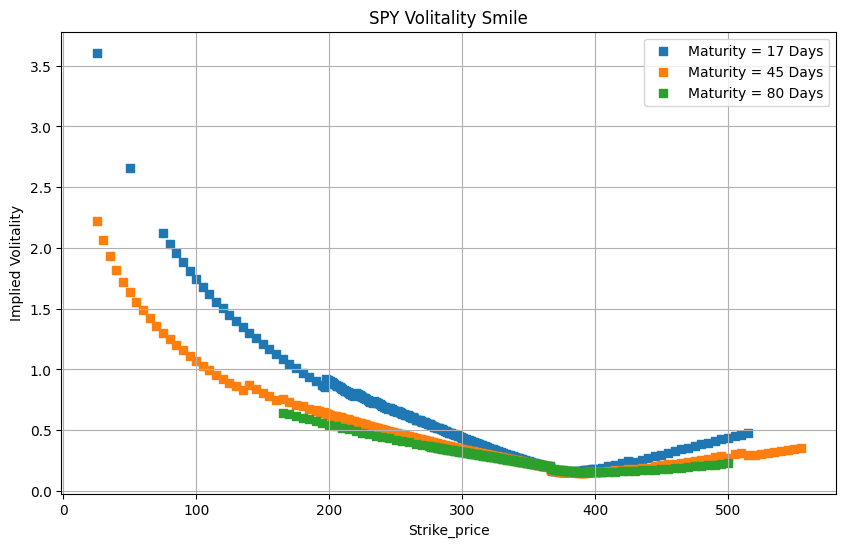

In [10]:
spy_smile = get_lognormal_smile(df_spy,df_zero,S0_spy)
plot_lognormal_smile(spy_smile,"SPY")

## <a id = "p2"> 2. </a> Bachelier Model [back to table of contents](#top)

To plot the implied volatility smile for the normal (Bachelier) model, just replaced the "BlackScholesCall" with the Bachelier formula.

##### <a id = "p21"> </a> Generate Normal vol [back to table of contents](#top)

In [11]:
def Bachelier(S, K, r, sigma, T, payoff):
    d = (K - S) / (sigma * np.sqrt(T))
    if payoff == "C":
        return np.exp(-r*T) * ((S - K) * norm.cdf(-d) + sigma * np.sqrt(T) *norm.pdf(-d))
    elif payoff == "P":
        return np.exp(-r*T) * ((K - S) * norm.cdf(d) + sigma * np.sqrt(T) *norm.pdf(d))
def normalVol(S, K, r, price, T, payoff):
    try:
        normVol = brentq(lambda x: price -
                            Bachelier(S, K, r, x, T, payoff),
                            1e-6, 1000000.0)
    except Exception:
        normVol = np.nan

    return normVol

In [12]:
def get_normal_smile(Option,Rate,S0):
    start_date = pd.Timestamp(str(df_spx["date"].unique()[0])).date()
    Option["T"] = Option["exdate"].apply(
        lambda x:(pd.Timestamp(str(x)).date() - start_date).days)
    Option["r"] = Option["T"].apply(lambda x:np.interp(x,Rate["days"],Rate["rate"])/100)

    Option["F"] = S0 * np.exp(Option["r"] * Option["T"] / 365)

    ### filter out ITM options which is unliquid
    call = Option[Option["cp_flag"] == "C"]
    call["mid_price"] = (call["best_bid"] + call["best_offer"])/2
    call = call[call["strike_price"]/1000 >= S0]

    put = Option[Option["cp_flag"] == "P"]
    put["mid_price"] = (put["best_bid"] + put["best_offer"])/2
    put = put[put["strike_price"]/1000 <= S0]

    df_smile = pd.concat([put,call])
    df_smile["impvol"] = df_smile.apply(lambda x:
                                        normalVol(S0, 
                                                  x["strike_price"]/1000, 
                                                  x["r"], 
                                                  x["mid_price"], 
                                                  x["T"]/365,
                                                  x["cp_flag"]),
                                        axis = 1)
    smiles = []
    for T in df_smile["T"].unique():
        smiles += [df_smile[df_smile["T"] == T]]
    return smiles

def plot_normal_smile(smiles,name):
    plt.figure(figsize=(10, 6))

    for i, df in enumerate(smiles):
        y_values = df['impvol']
        plt.scatter(df['strike_price'] / 1000, y_values, marker='s',\
                    label=f"Maturity = {df['T'].iloc[0]} Days")

    plt.xlabel('Strike_price')
    plt.ylabel('Implied Volitality')
    plt.title(f'{name} Volitality Smile')
    plt.legend()

    plt.grid(True)
    plt.show()   

##### <a id = "p22"> </a> Normal volatility Smile [back to table of contents](#top)

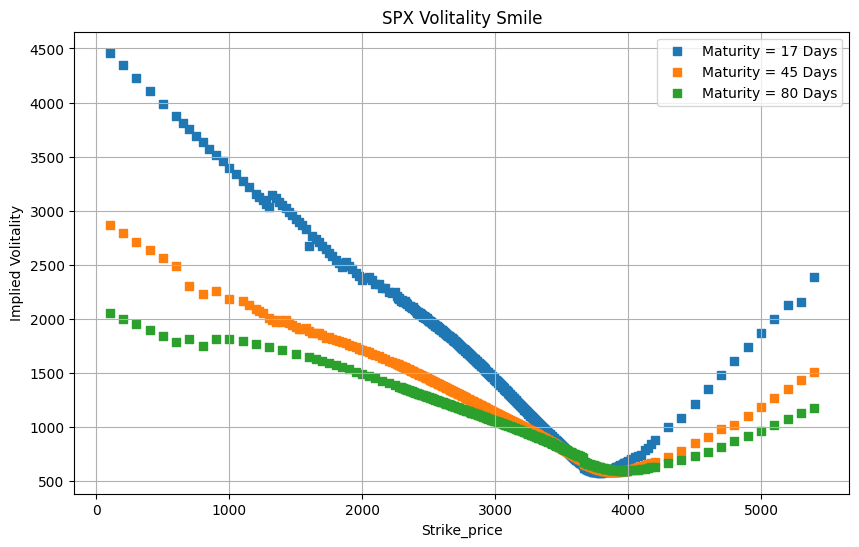

In [13]:
spx_normal_smile = get_normal_smile(df_spx,df_zero,S0_spx)
plot_normal_smile(spx_normal_smile,"SPX")

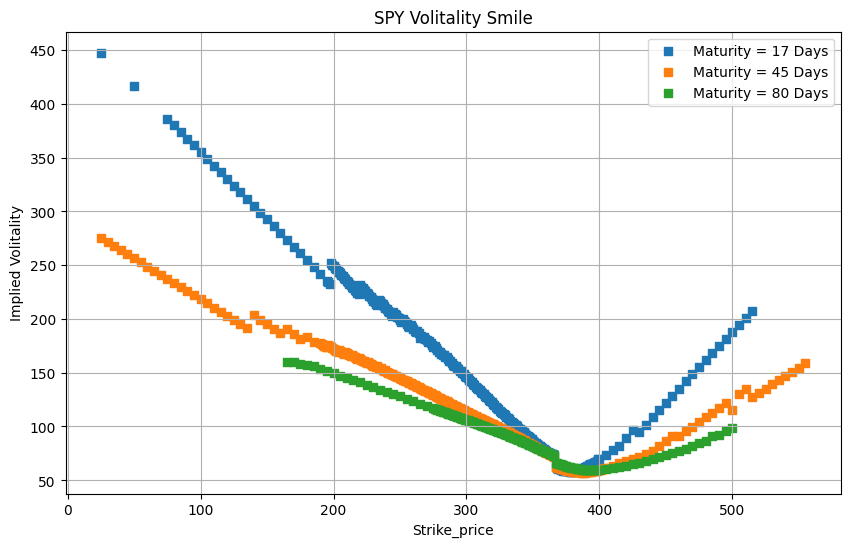

In [14]:
spy_normal_smile = get_normal_smile(df_spy,df_zero,S0_spy)
plot_normal_smile(spy_normal_smile,"SPY")

##### <a id = "p23"> </a> Lognormal vs Normal vol [back to table of contents](#top)

In [24]:
def find_ATM(df,S0):
    ATM = df.copy()
    ATM["diff"] = abs(ATM["strike_price"]/1000 - S0)
    ATM = ATM.sort_values(by = "diff").head(1)
    K = ATM["strike_price"].iloc[0]/1000
    r = ATM["r"].iloc[0]
    price = ATM["mid_price"].iloc[0]
    T = ATM["T"].iloc[0]/365
    flag = ATM["cp_flag"].iloc[0]
    ATM_vol = impliedVol(S0, K, r, price, T, flag)
    return ATM_vol

In [44]:
def get_norm_vol(S, K, r, ATM_sigma, T, payoff):
    Bach_price = Bachelier(S, K, r, ATM_sigma*S, T, payoff)
    return impliedVol(S, K, r, Bach_price, T, payoff)


In [28]:
def plot_lognormalVSnormal_smile(df,S,name):
    df_vs = df.copy()
    atm_vol = find_ATM(df_vs,S)
    df_vs["normvol"] = df_vs.apply(lambda x:get_norm_vol(S, 
                                                         x["strike_price"]/1000, 
                                                         x["r"], 
                                                         atm_vol, 
                                                         x["T"]/365, 
                                                         x["cp_flag"]),
                                   axis = 1)
    df_vs.dropna(inplace = True)
    
    plt.figure(figsize = (10,6))
    plt.plot(df_vs['strike_price'] / 1000, df_vs["normvol"],color = "blue",
             label="Normal Vol")
    plt.plot(df_vs['strike_price'] / 1000, [atm_vol]*len(df_vs),color = "black",
             label="Lognormal Vol")
    plt.xlabel('Strike_price')
    plt.ylabel('Implied Volitality')
    plt.legend()
    plt.title(f"{name} Market Maturity = {df_vs['T'].iloc[0]} Days")
    plt.show()

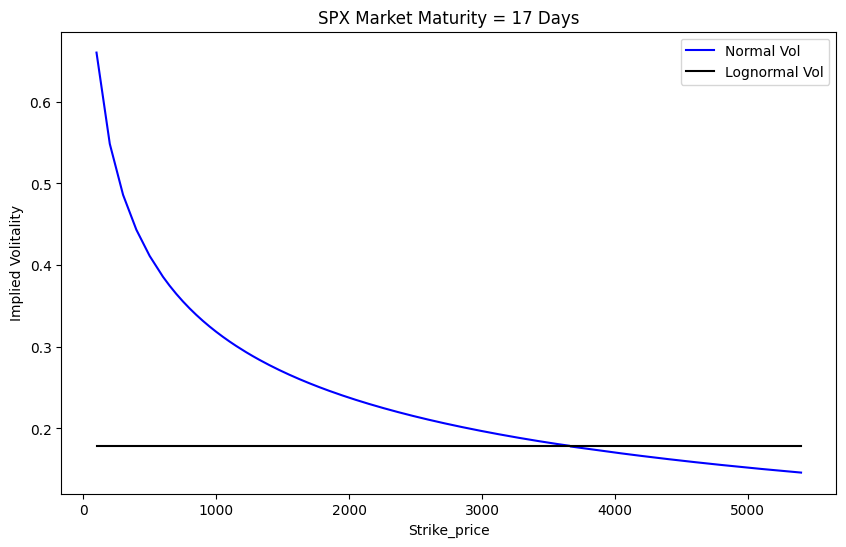

In [29]:

plot_lognormalVSnormal_smile(spx_smile[0],S0_spx,"SPX")

## <a id = "p3"> 3. </a> Displaced Diffusion Model [back to table of contents](#top)

##### <a id = "p31"> </a> ATM Volatility [back to table of contents](#top)

In [30]:
print("SPX ATM vol")
for i, df in enumerate(spx_smile):
    T = df["T"].unique()[0]
    atm_vol = find_ATM(df,S0_spx)
    print(f"The ATM vol for T = {T} is {atm_vol}.")

print("SPY ATM vol")
for i, df in enumerate(spy_smile):
    T = df["T"].unique()[0]
    atm_vol = find_ATM(df,S0_spy)
    print(f"The ATM vol for T = {T} is {atm_vol}.")

SPX ATM vol
The ATM vol for T = 17 is 0.1782149623160521.
The ATM vol for T = 45 is 0.18886028486826037.
The ATM vol for T = 80 is 0.1971743122033464.
SPY ATM vol
The ATM vol for T = 17 is 0.20155137730633524.
The ATM vol for T = 45 is 0.19776672329627487.
The ATM vol for T = 80 is 0.200652689513227.


The Displaced-Diffussion is a **shifted lognormal** process, which comprises features of normal and lognormal models. The DD formula for option price can be given by Black

\begin{equation}
\begin{split}
Displaced-Diffussion &= Black(\frac{F_0}{\beta},K+\frac{1-\beta}{\beta}F_0,\sigma \beta,T)\\
C(F_0,K,r,\sigma,T,\beta) &= e^{-rT} (\frac{F_0}{\beta} \Phi(d_1) - (K + \frac{1-\beta}{\beta}F_0) \Phi(d_2))\\
            d_1 &= \frac{\log( \frac{F_0}{\beta K + (1-\beta)F_0}) +
            \left(\frac{\beta^2 \sigma^2}{2}\right)T}{\beta \sigma\sqrt{T}}, \hspace{2cm} d_2 = d_1 - \beta \sigma\sqrt{T}\\
\end{split}            
\end{equation}


In [31]:
def DisplacedDiffussion(F0, K, r, sigma, T, payoff, beta):
    F_ = F0/beta
    K_ = K + (1-beta)/beta * F0
    sigma_ = sigma * beta
    d1 = (np.log(F_/K_)+(sigma_**2/2)*T) / (sigma_*np.sqrt(T))
    d2 = d1 - sigma_*np.sqrt(T)
    if payoff == "C":
        return np.exp(-r*T) * (F_* norm.cdf(d1) - K_ * norm.cdf(d2))
    elif payoff == "P":
        return np.exp(-r*T) * (K_ * norm.cdf(-d2) - F_ * norm.cdf(-d1))

In [32]:
def get_DD_sigma(F0, K, r, ATM_sigma, T, payoff, beta, S):
    DD_price = DisplacedDiffussion(F0, K, r, ATM_sigma, T, payoff, beta)
    return impliedVol(S, K, r, DD_price, T, payoff)

In [33]:
def plot_DD_smile_adjusted(df,S,name):
    df_DD = df.copy()
    beta_list = [0.2,0.4,0.6,0.8]
    atm_vol = find_ATM(df_DD,S)

    plt.figure(figsize = (10,6))

    plt.plot(df_DD['strike_price'] / 1000, [atm_vol]*len(df_DD),color = "black",
             label="Lognormal Vol")
    plt.plot(df_DD['strike_price'] / 1000, df_DD["impvol"],color = "red",
             label="Market Vol")
    for beta in beta_list:
        df_DD["DDvol"] = df_DD.apply(lambda x:get_DD_sigma(S, 
                                                           x["strike_price"]/1000, 
                                                           x["r"], 
                                                           atm_vol, 
                                                           x["T"]/365, 
                                                           x["cp_flag"], 
                                                           beta, S),
                                     axis = 1)
        df_DD.dropna(inplace = True)
        plt.plot(df_DD['strike_price'] / 1000, df_DD["DDvol"], linestyle='-',
                    label=f"beta = {beta}")
#     print(df_DD)
    plt.xlabel('Strike_price')
    plt.ylabel('Implied Volitality')
    plt.legend()
    plt.title(f"{name} Market Maturity = {df_DD['T'].iloc[0]} Days")
    plt.show()

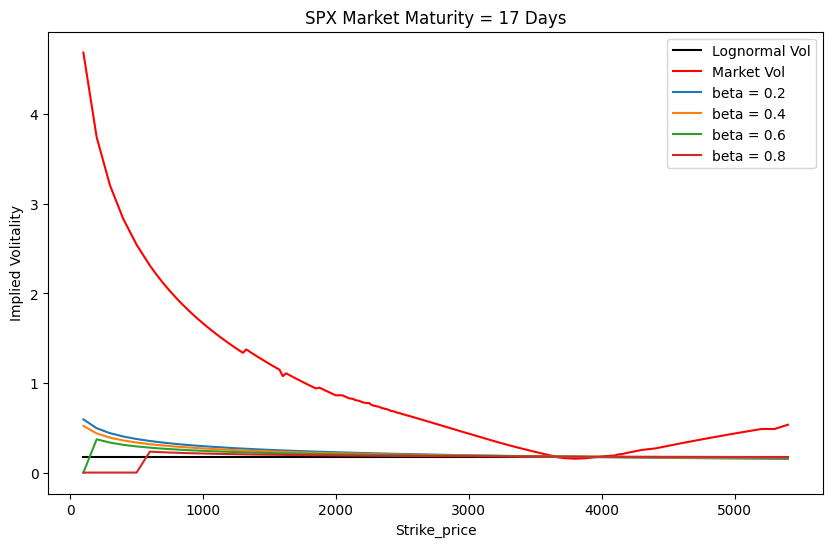

In [34]:
plot_DD_smile_adjusted(spx_smile[0],S0_spx,"SPX")

##### <a id = "p32"> </a>  DD Calibration [back to table of contents](#top)

In [35]:
def DD_Calib(df, S, beta):
    df_DD = df.copy()
    atm_vol = find_ATM(df_DD,S)
    df_DD["DDvol"] = df_DD.apply(lambda x:get_DD_sigma(x["F"], 
                                                       x["strike_price"]/1000, 
                                                       x["r"], 
                                                       atm_vol, 
                                                       x["T"]/365, 
                                                       x["cp_flag"], 
                                                       beta, S),
                                 axis = 1)
    df_DD.dropna(inplace = True)
#     print(df_DD)
    err = ((df_DD["DDvol"] - df_DD["impvol"])**2).sum()
    return err

def get_DD_param(df,S,initial_guess):
    res = least_squares(lambda x: DD_Calib(df, S, x),
                        initial_guess, bounds = (0,1))
    beta = res.x[0]
    return beta

In [36]:
def plot_DD_smile(df,S,name,initial_guess):
    df_DD = df.copy()
    beta = get_DD_param(df_DD,S,initial_guess)
    atm_vol = find_ATM(df_DD,S)
    df_DD["DDvol"] = df_DD.apply(lambda x:get_DD_sigma(x["F"], 
                                                       x["strike_price"]/1000, 
                                                       x["r"], 
                                                       atm_vol, 
                                                       x["T"]/365, 
                                                       x["cp_flag"], 
                                                       beta, S),
                                 axis = 1)
    df_DD.dropna(inplace = True)
    plt.figure(figsize = (10,6))
    plt.scatter(df_DD['strike_price'] / 1000, df_DD["impvol"], marker='s',color = "blue",
                    label="Market Vol")
    plt.plot(df_DD['strike_price'] / 1000, df_DD["DDvol"], linestyle='-',color = "red",
                    label="Displaced Diffussion Model")
    plt.xlabel('Strike_price')
    plt.ylabel('Implied Volitality')
    plt.legend()
    plt.title(f"{name} Market Maturity = {df_DD['T'].iloc[0]} Days")
    plt.show()
    



##### <a id = "p33"> </a>  DD Smile [back to table of contents](#top)

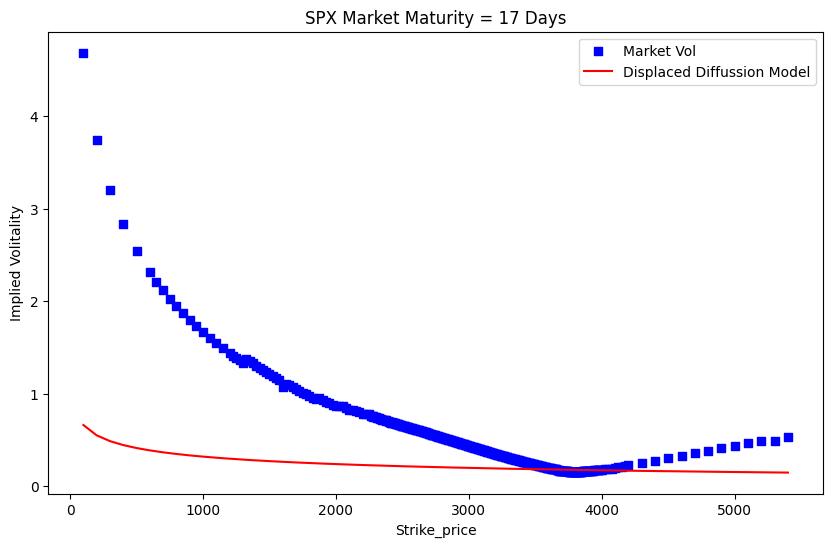

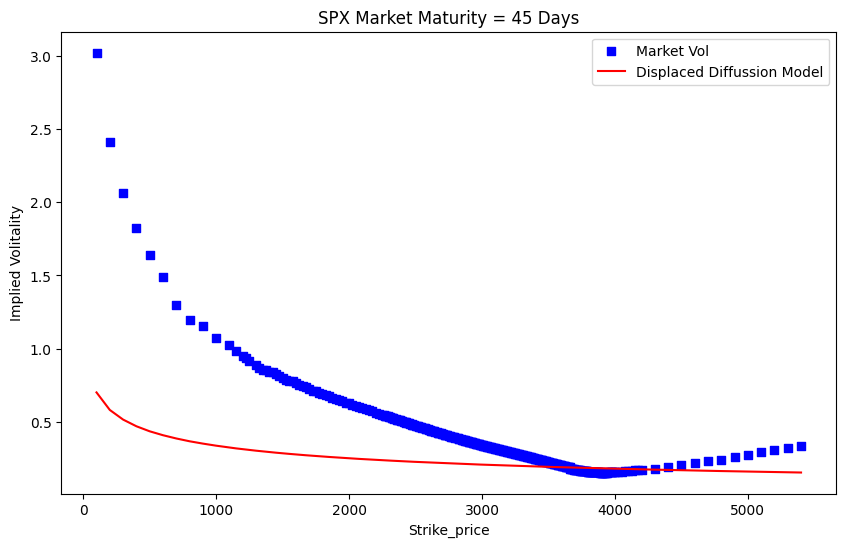

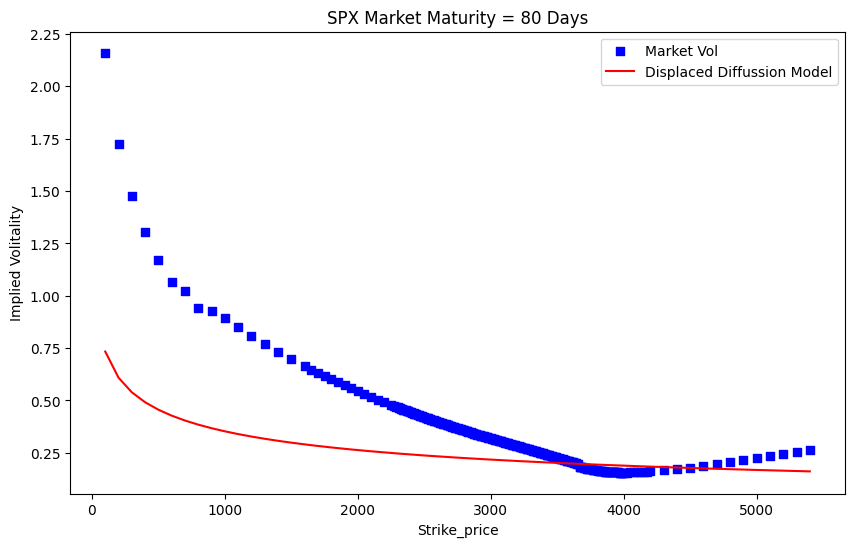

In [37]:
initial_guess = 0.7

plot_DD_smile(spx_smile[0],S0_spx,"SPX",initial_guess)
plot_DD_smile(spx_smile[1],S0_spx,"SPX",initial_guess)
plot_DD_smile(spx_smile[2],S0_spx,"SPX",initial_guess)

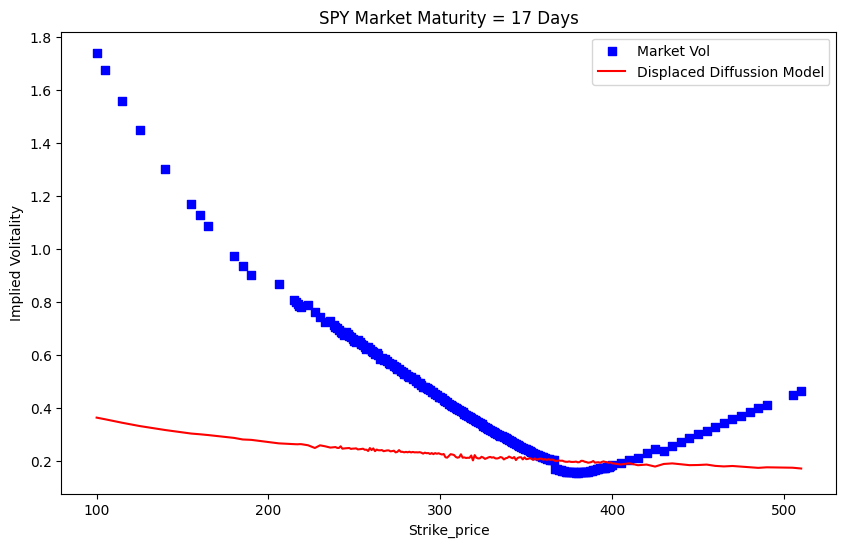

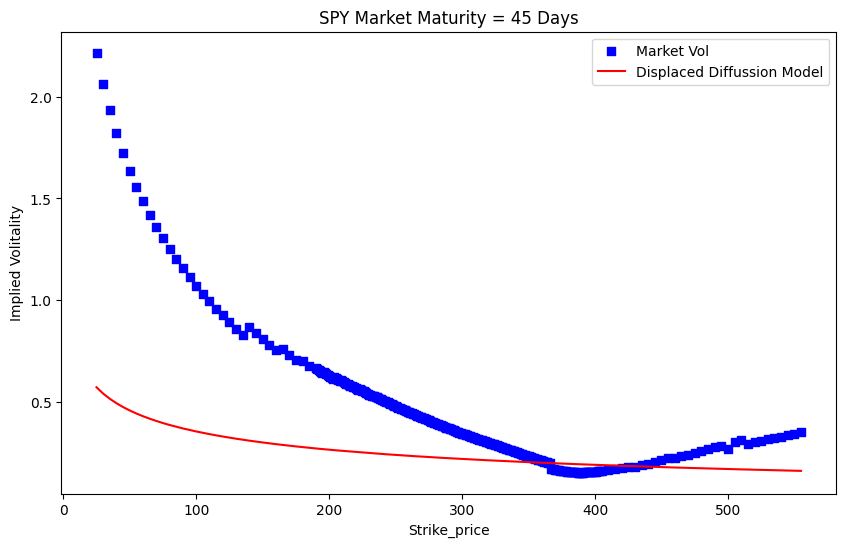

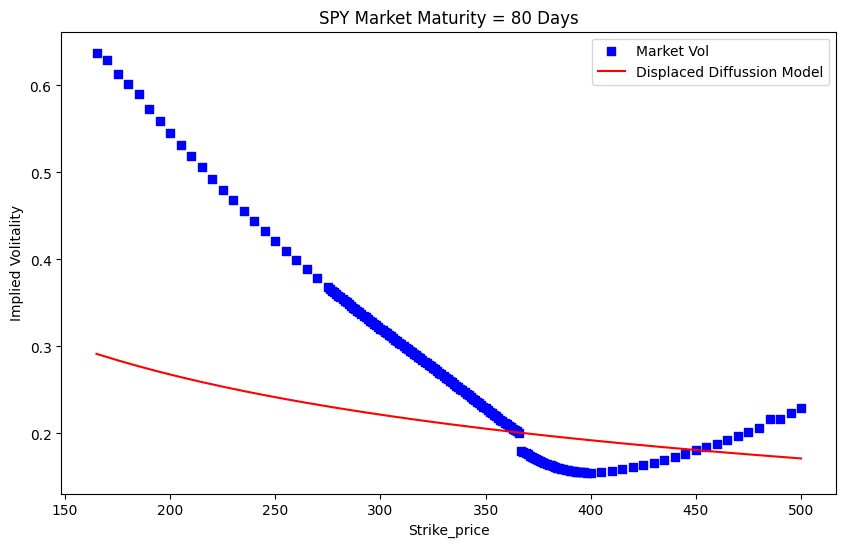

In [38]:
plot_DD_smile(spy_smile[0],S0_spy,"SPY",initial_guess)
plot_DD_smile(spy_smile[1],S0_spy,"SPY",initial_guess)
plot_DD_smile(spy_smile[2],S0_spy,"SPY",initial_guess)

## <a id = "p4"> 4. </a> SABR  [back to table of contents](#top)

First, we shall implement the SABR model. The implied Black volatility of the SABR model is given by
  \begin{equation*}
    \begin{split}
      &\sigma_{\mbox{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) \\
      &= \frac{\alpha}{(F_0K)^{(1-\beta)/2}\left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots\right\} } \\
      &\;\;\;\times \frac{z}{x(z)} \times \left\{ 1 + \left[
          \frac{(1-\beta)^2}{24}
          \frac{\alpha^2}{(F_0K)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(F_0K)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}\nu^2\right]
        T + \cdots \right.
    \end{split}
  \end{equation*}
  where
  \begin{equation*}
    \begin{split}
      z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2}
      \log\left(\frac{F_0}{K}\right),
    \end{split}
  \end{equation*}
  and
  \begin{equation*}
    \begin{split}
      x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}
      \right].
    \end{split}
  \end{equation*}


This can be implemented in Python as follows:

\begin{equation*}
   \begin{split}
     x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}
     \right].
   \end{split}
 \end{equation*}

$x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}
     \right]$

In [39]:
def get_SABR_sigma(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

##### <a id = "p41">  </a> Calibrate SABR Model [back to table of contents](#top)

We look at the SABR model. The definition above contains the function

\begin{equation*}
\begin{split}
\mbox{SABR}(F, K, T, \alpha, \beta, \rho, \nu)
\end{split}
\end{equation*}

The function returns a volatility $\sigma_{\mbox{SABR}}$ for the Black76Lognormal call or put option formula, so that

\begin{equation*}
\begin{split}
\mbox{Call price} &= \mbox{BlackScholesCall}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\mbox{Put price} &= \mbox{BlackScholesPut}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\end{split}
\end{equation*}

How do we determine the parameters $\alpha$, $\rho$ and $\nu$?
- We choose them so that the output of the SABR model matches the implied volatilities observed in the market.
- We refer to this process as "model calibration".

In other words, defining

  \begin{equation*}
    \begin{split}
      \sigma_{\mbox{Mkt}}(K_1) - \mbox{SABR}(F, K_1, T, \alpha, 0.8, \rho, \nu) &= \epsilon_1 \\
      \sigma_{\mbox{Mkt}}(K_2) - \mbox{SABR}(F, K_2, T, \alpha, 0.8, \rho, \nu) &= \epsilon_2 \\
      \vdots&\\
      \sigma_{\mbox{Mkt}}(K_n) - \mbox{SABR}(F, K_n, T, \alpha, 0.8, \rho, \nu) &= \epsilon_n \\
    \end{split}
  \end{equation*}

We want to minimize the sum of squared error terms as follows:
  
  \begin{equation*}
    \begin{split}
      \min_{\substack{\alpha,\; \rho,\; \nu}} \;\sum_{i=1}^n \epsilon_i^2
    \end{split}
  \end{equation*}

We use the "least_squares" algorithm in "scipy" package to calibrate the SABR model parameters:


In [40]:
def SABR_Calib(df, S, guess,beta):
    df_SABR = df.copy()
    df_SABR["SABRvol"] = df_SABR.apply(lambda x:get_SABR_sigma(x["F"], 
                                                               x["strike_price"]/1000, 
                                                               x["T"]/365, 
                                                               guess[0], 
                                                               beta, 
                                                               guess[1], 
                                                               guess[2]),
                                 axis = 1)
    df_SABR.dropna(inplace = True)
#     print(df_SABR)
    err = ((df_SABR["SABRvol"] - df_SABR["impvol"])**2).sum()
    return err

def get_SABR_param(df, S, beta):
    initial_guess = [0.02, 0.2, 0.1]
    ### be attention to the bounds!!!
    bounds = ([0,-1,0],[float("inf"),1,float("inf")])
    res = least_squares(lambda x: SABR_Calib(df, S, x, beta),
                        initial_guess, bounds = bounds)
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]
    return alpha, beta, rho, nu

In [41]:
def plot_SABR_smile(df,S,name,beta):
    df_SABR = df.copy()
    alpha, beta, rho, nu = get_SABR_param(df_SABR, S,beta)
    atm_vol = find_ATM(df_SABR, S)
    df_SABR["SABRvol"] = df_SABR.apply(lambda x:get_SABR_sigma(x["F"], 
                                                               x["strike_price"]/1000, 
                                                               x["T"]/365, 
                                                               alpha, 
                                                               beta, 
                                                               rho,
                                                               nu),
                                         axis = 1)
    df_SABR.dropna(inplace = True)
    plt.figure(figsize = (10,6))
    plt.scatter(df_SABR['strike_price'] / 1000, df_SABR["impvol"], marker='s',color = "blue",
                    label="Market Vol")
    plt.plot(df_SABR['strike_price'] / 1000, df_SABR["SABRvol"], linestyle='-',color = "red",
                    label="SABR Model")
    plt.xlabel('Strike_price')
    plt.ylabel('Implied Volitality')
    plt.legend()
    plt.title(f"{name} Market Maturity = {df_SABR['T'].iloc[0]} Days")
    plt.show()
    

##### <a id = "p42">  </a> SABR Smile [back to table of contents](#top)

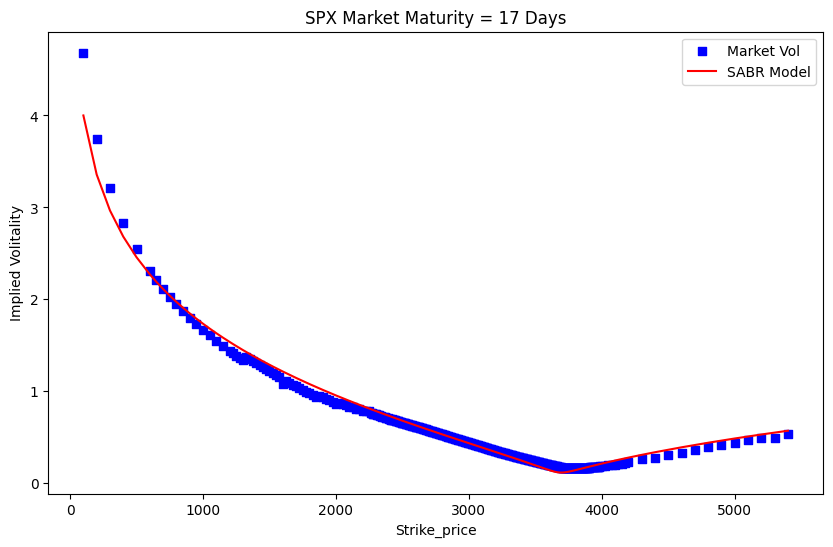

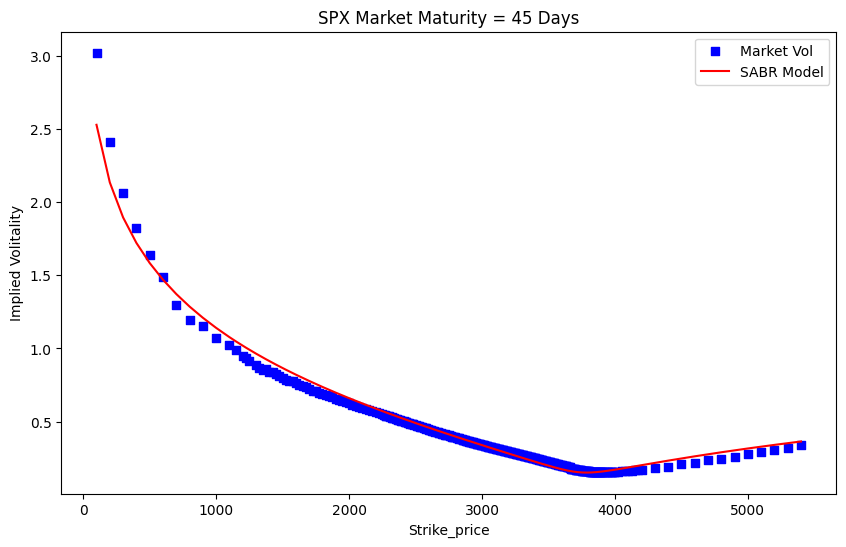

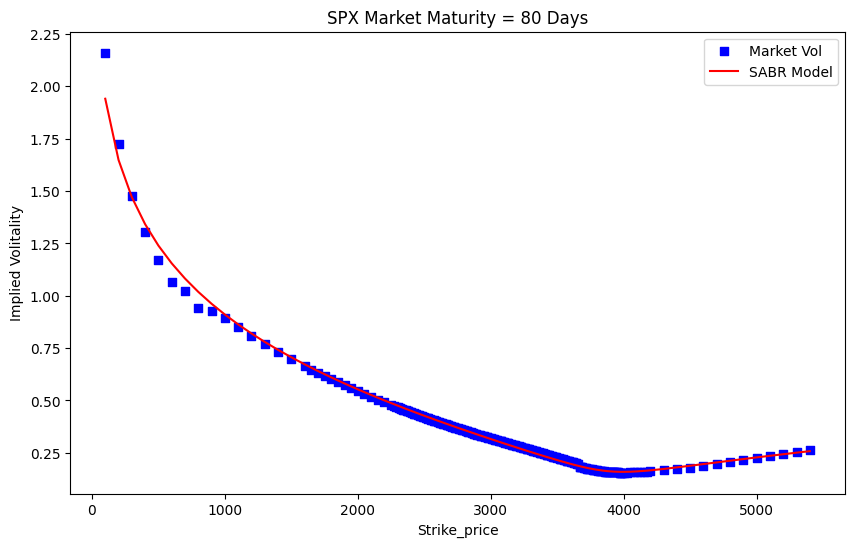

In [42]:
beta = 0.7

plot_SABR_smile(spx_smile[0],S0_spx,"SPX",beta)
plot_SABR_smile(spx_smile[1],S0_spx,"SPX",beta)
plot_SABR_smile(spx_smile[2],S0_spx,"SPX",beta)

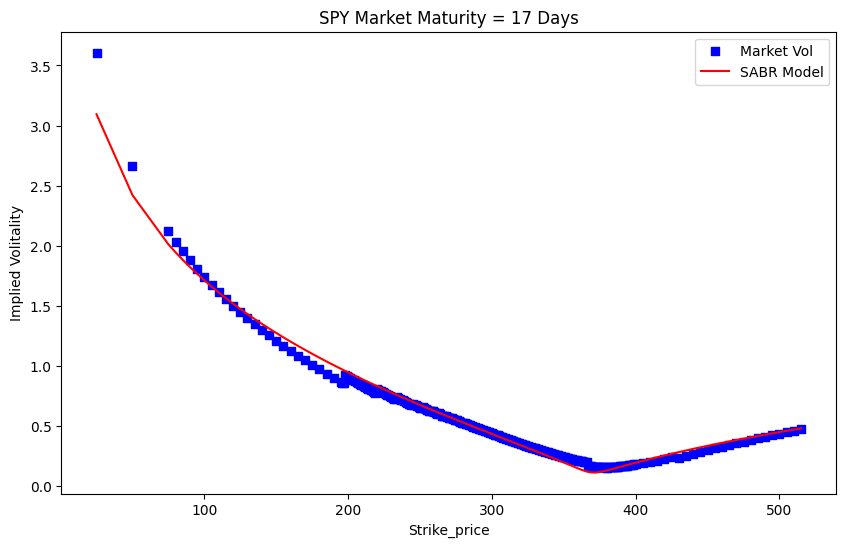

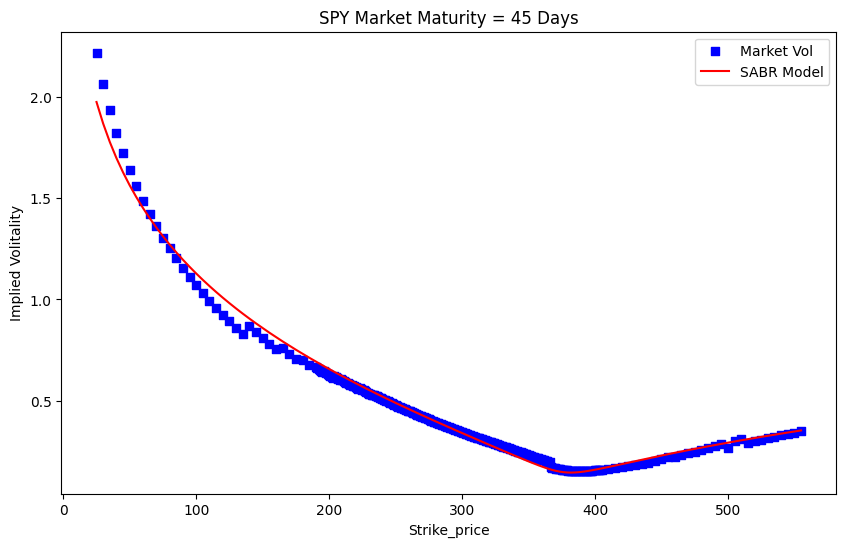

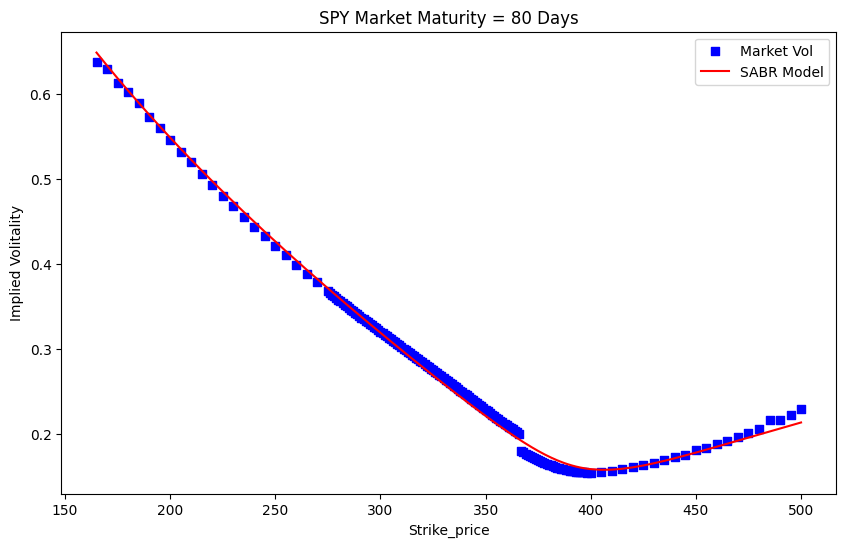

In [43]:
plot_SABR_smile(spy_smile[0],S0_spy,"SPY",beta)
plot_SABR_smile(spy_smile[1],S0_spy,"SPY",beta)
plot_SABR_smile(spy_smile[2],S0_spy,"SPY",beta)